In [1]:
%matplotlib inline
import sys
BIN = '../../'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms
import matplotlib as mpl
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

from fastai import data_block, basic_train, basic_data
import fastai

In [2]:
from my_nn_modules import AE_basic, AE_bn, AE_LeakyReLU, AE_bn_LeakyReLU

In [3]:
# Load data
#train = pd.read_pickle(BIN + 'processed_data/aod/partial_train.pkl')
#test = pd.read_pickle(BIN + 'processed_data/aod/partial_test.pkl')

#train = pd.read_pickle(BIN + 'processed_data/aod/full_train.pkl')
#test = pd.read_pickle(BIN + 'processed_data/aod/full_test.pkl')

#train = pd.read_pickle(BIN + 'processed_data/aod/all_jets_partial_train.pkl')
#test = pd.read_pickle(BIN + 'processed_data/aod/all_jets_partial_test.pkl')

train = pd.read_pickle(BIN + 'processed_data/aod/all_jets_partial_train_10percent.pkl')
print('Original train.shape:', train.shape)
test = pd.read_pickle(BIN + 'processed_data/aod/all_jets_partial_test_10percent.pkl')

#train = pd.read_pickle(BIN + 'processed_data/aod/all_jets_full_train.pkl')
#test = pd.read_pickle(BIN + 'processed_data/aod/all_jets_full_test.pkl')

train['pt'] = train['pt'] / 1000.  # Convert to GeV
test['pt'] = test['pt'] / 1000.  # Convert to GeV
train['m'] = train['m'] / 1000.  # Convert to GeV
test['m'] = test['m'] / 1000.  # Convert to GeV

train['LeadingClusterPt'] = train['LeadingClusterPt'] / 1000.  # Convert to GeV
test['LeadingClusterPt'] = test['LeadingClusterPt'] / 1000.  # Convert to GeV

train['LeadingClusterSecondR'] = train['LeadingClusterSecondR'] / 1000.  # Convert to GeV
test['LeadingClusterSecondR'] = test['LeadingClusterSecondR'] / 1000.  # Convert to GeV

train['LeadingClusterSecondLambda'] = train['LeadingClusterSecondLambda'] / 1000.  # Convert to GeV
test['LeadingClusterSecondLambda'] = test['LeadingClusterSecondLambda'] / 1000.  # Convert to GeV

train['NegativeE'] = train['NegativeE'] / 1000.  # Convert to GeV
test['NegativeE'] = test['NegativeE'] / 1000.  # Convert to GeV

train.pop('JetGhostArea')
test.pop('JetGhostArea')
train.pop('BchCorrCell')
test.pop('BchCorrCell')

#train.pop('ActiveArea')
#test.pop('ActiveArea')
#train.pop('ActiveArea4vec_pt')
#test.pop('ActiveArea4vec_pt')
#train.pop('N90Constituents')
#test.pop('N90Constituents')


# Remove all jets with EMFrac outside (-2, 2)
train = train[(np.abs(train['EMFrac']) < 5)]
test = test[(np.abs(test['EMFrac']) < 5)]

train = train[np.invert((np.abs(train['EMFrac']) < 0.05) & (np.abs(train['eta']) >= 2))]
test = test[np.invert((np.abs(test['EMFrac']) < 0.05) & (np.abs(test['eta']) >= 2))]

train = train[np.invert((train['AverageLArQF'] > .8) & (train['EMFrac'] > .95) & (train['LArQuality'] > .8) & (np.abs(train['eta']) < 2.8))]
test = test[np.invert((test['AverageLArQF'] > .8) & (test['EMFrac'] > .95) & (test['LArQuality'] > .8) & (np.abs(test['eta']) < 2.8))]

train = train[np.abs(train['NegativeE']) < 60 * 5]
test = test[np.abs(test['NegativeE']) < 60 * 5]

# Filter out extreme jets
train = train[np.invert((train['AverageLArQF'] > .8) & (np.abs(train['HECQuality']) > 0.5) & (np.abs(train['HECFrac']) > 0.5))]
test = test[np.invert((test['AverageLArQF'] > .8) & (np.abs(test['HECQuality']) > 0.5) & (np.abs(test['HECFrac']) > 0.5))]

train = train[train['OotFracClusters10'] > -0.1]
test = test[test['OotFracClusters10'] > -0.1]
train = train[train['OotFracClusters5'] > -0.1]
test = test[test['OotFracClusters5'] > -0.1]

train = train[np.abs(train['Width']) < 5]
test = test[np.abs(test['Width']) < 5]

train = train[np.invert(train['Width'] == -1)]
test = test[np.invert(test['Width'] == -1)]

train = train[np.abs(train['WidthPhi']) < 5]
test = test[np.abs(test['WidthPhi']) < 5]
          
train = train[np.abs(train['Timing']) < 125]
test = test[np.abs(test['Timing']) < 125]

train = train[train['LArQuality'] < 4]
test = test[test['LArQuality'] < 4]

train = train[np.abs(train['HECQuality']) < 2.5]
test = test[np.abs(test['HECQuality']) < 2.5]

#train = train[train['m'] > 0]
#test = test[test['m'] > 0]

# train = train[train['m'] > 1e-3]
# test = test[test['m'] > 1e-3]

Original tran.shape: (956154, 29)


In [4]:
train.shape

(952063, 27)

In [5]:
print('Number of jets excluded:')
(956154 - 952063)

Number of jets excluded:


4091

In [6]:
np.sum(train['m']==0)

5064

In [7]:
len(train.keys())

27

In [8]:
train.head()

,pt,eta,phi,m,ActiveArea,ActiveArea4vec_eta,ActiveArea4vec_m,ActiveArea4vec_phi,ActiveArea4vec_pt,AverageLArQF,...,LeadingClusterCenterLambda,LeadingClusterPt,LeadingClusterSecondLambda,LeadingClusterSecondR,N90Constituents,EMFrac,HECFrac,Timing,OotFracClusters10,OotFracClusters5
0,99.859094,-0.342858,2.134567,8.093726,0.478719,-0.353398,0.132767,2.131208,0.469330,108.751984,...,1264.798706,25.836232,343.890344,43.809391,5.0,0.612864,0.000000,0.864557,0.007613,0.017692
1,45.352539,-0.454986,-2.667796,6.373730,0.498666,-0.469833,0.140288,-2.671408,0.489406,837.354065,...,1027.079468,19.099195,54.438531,72.658773,6.0,0.509103,0.000000,11.380662,0.495797,0.590913
2,26.483807,1.440664,1.628155,5.337418,0.538559,1.447917,0.156741,1.641177,0.527291,293.155884,...,95.400406,4.939110,2.175471,5.361905,5.0,0.401359,0.000000,1.700485,0.188751,0.188751
3,21.745404,-0.112350,-2.588387,4.982306,0.448799,-0.128731,0.126130,-2.650139,0.442389,263.850281,...,84.082619,10.380062,20.607902,6.131678,8.0,0.863900,0.000000,1.283107,0.090132,0.145812
4,87.560859,-2.752789,-2.295353,16.907717,0.518612,-2.782047,0.150488,-2.293478,0.508540,3159.353760,...,921.882202,39.378828,81.567531,13.050796,4.0,0.565845,0.434155,-1.213494,0.000000,0.000000


In [9]:
def plot_all(data, logy=False):
    for key in data.keys():
        plt.figure()
        plt.hist(data[key], bins=200)
        plt.xlabel(str(key))
        plt.ylabel('Number of jets')
        if logy:
            plt.yscale('log')
        else:
            ms.sciy()

In [10]:
plt.close('all')

/Users/ericwulff/miniconda3/envs/fastairoot/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


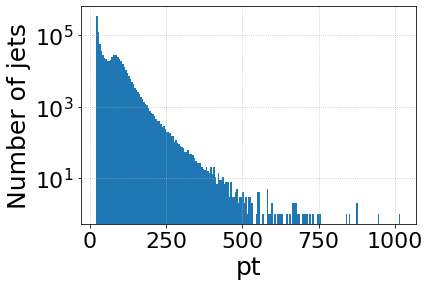

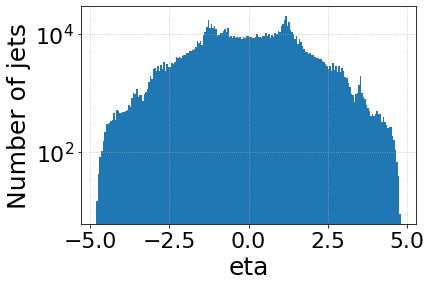

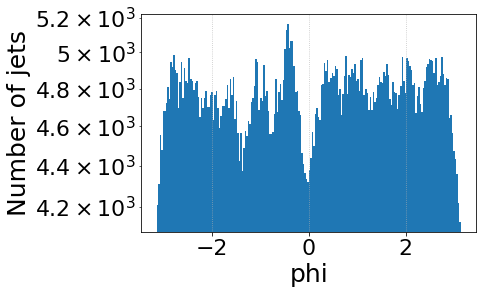

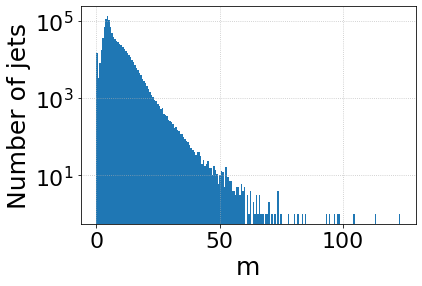

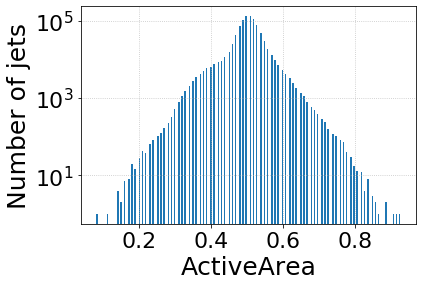

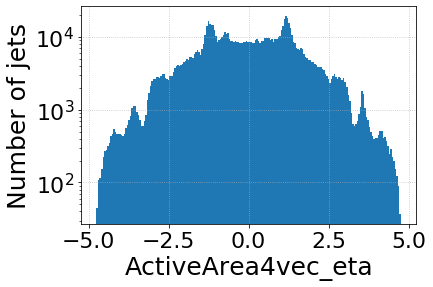

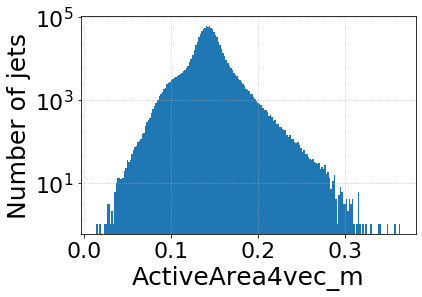

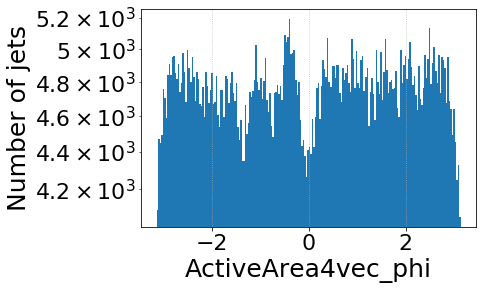

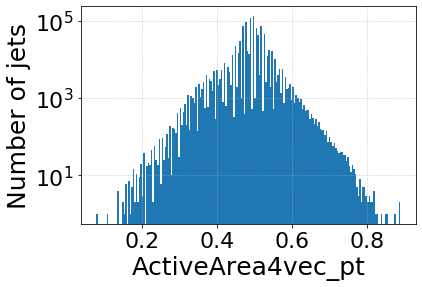

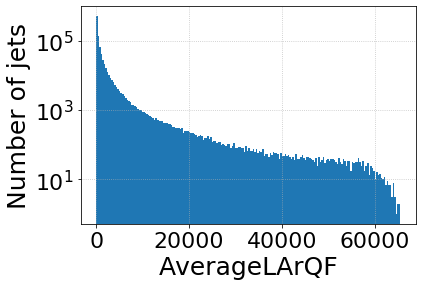

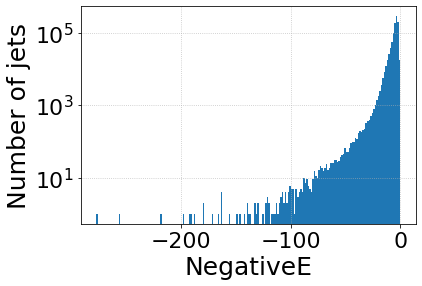

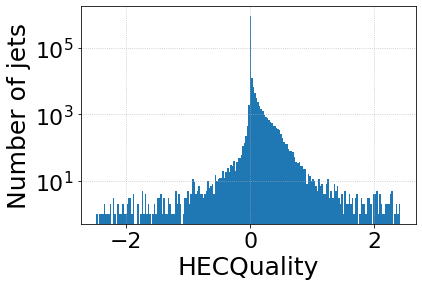

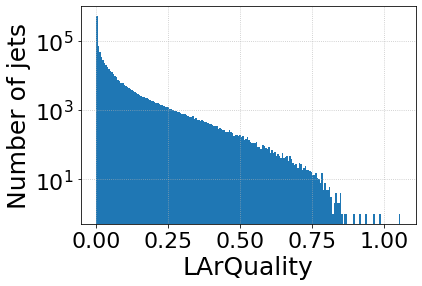

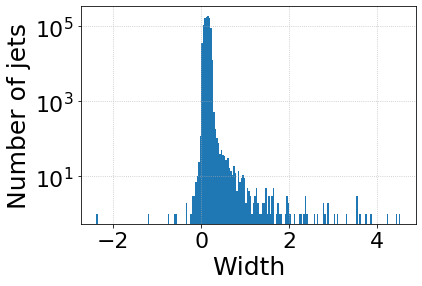

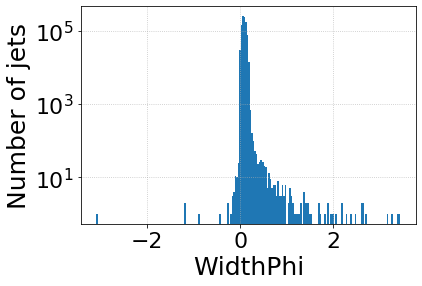

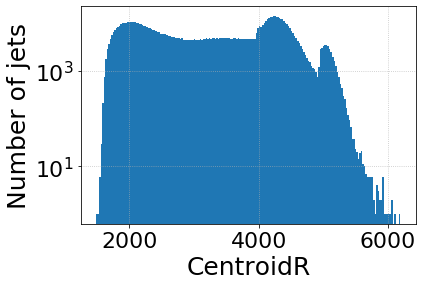

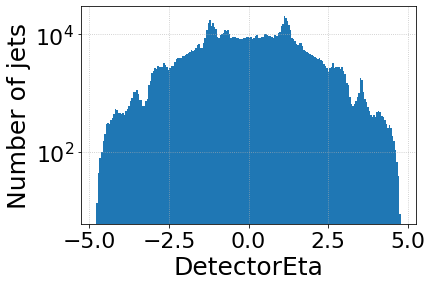

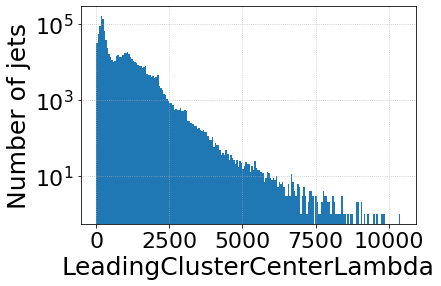

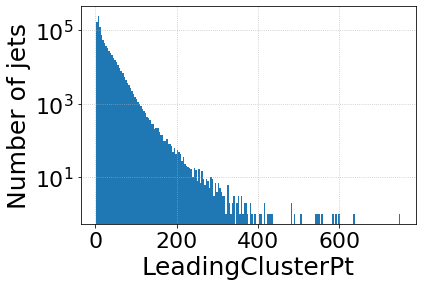

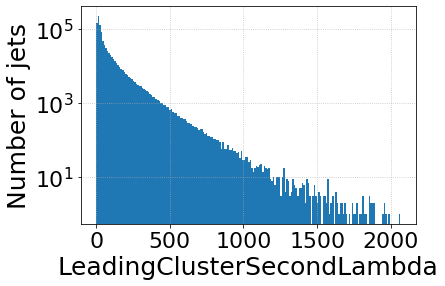

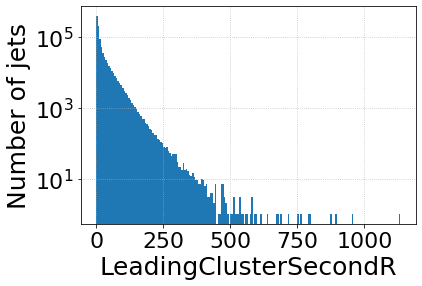

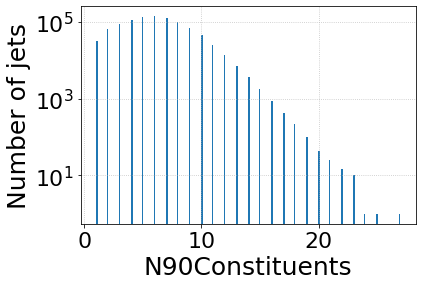

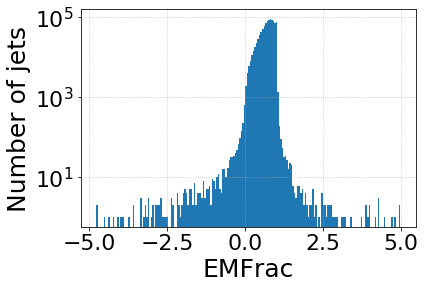

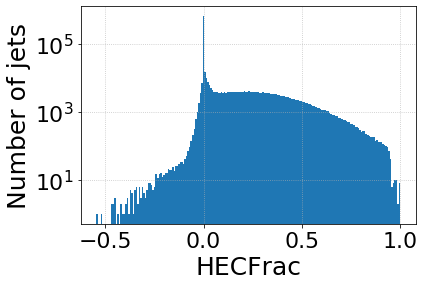

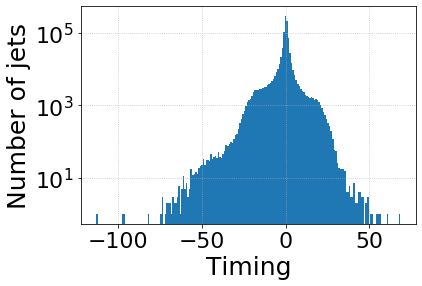

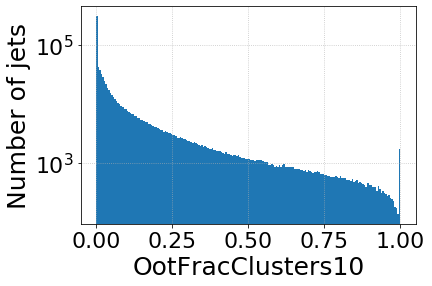

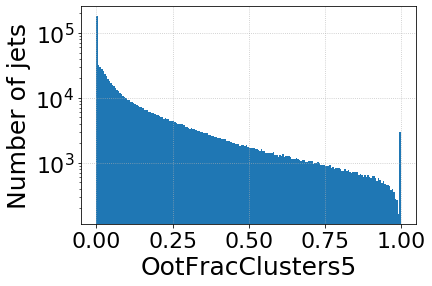

In [11]:
logy = True
plot_all(train, logy)

In [12]:
eta_div = 5
emfrac_div = 1.6
negE_div = 1.6
phi_div = 3
m_div = 1.8
width_div = .6
N90_div = 20
timing_div = 40
hecq_div = 1
centerlambda_div = 2
secondlambda_div = 1
secondR_div = .6
larqf_div = 2.5
pt_div = 1.2
centroidR_div = 0.8
area4vecm_div = 0.18
area4vecpt_div = 0.7
area4vec_div = 0.8
Oot_div = 0.3
larq_div = 0.6

log_add = 100
log_sub = 2
m_add = 1
centroidR_sub = 3
pt_sub = 1.3
area4vecm_sub = 0.15
    

def custom_normalization(train, test):
    train_cp = train.copy()
    test_cp = test.copy()
    
    for data in [train_cp, test_cp]:
        data['DetectorEta'] = data['DetectorEta'] / eta_div
        data['ActiveArea4vec_eta'] = data['ActiveArea4vec_eta'] / eta_div
        data['EMFrac'] = data['EMFrac'] / emfrac_div
        data['NegativeE'] = np.log10(-data['NegativeE'] + 1) / negE_div
        data['eta'] = data['eta'] / eta_div
        data['phi'] = data['phi'] / phi_div
        data['ActiveArea4vec_phi'] = data['ActiveArea4vec_phi'] / phi_div
        data['Width'] = data['Width'] / width_div
        data['WidthPhi'] = data['WidthPhi'] / width_div
        data['N90Constituents'] = data['N90Constituents'] / N90_div
        data['Timing'] = data['Timing'] / timing_div
        data['HECQuality'] = data['HECQuality'] / hecq_div
        data['ActiveArea'] = data['ActiveArea'] / area4vec_div
        data['ActiveArea4vec_m'] = data['ActiveArea4vec_m'] / area4vecm_div - area4vecm_sub
        data['ActiveArea4vec_pt'] = data['ActiveArea4vec_pt'] / area4vecpt_div
        data['LArQuality'] = data['LArQuality'] / larq_div

        data['m'] = np.log10(data['m'] + m_add) / m_div
        data['LeadingClusterCenterLambda'] = (np.log10(data['LeadingClusterCenterLambda'] + log_add) - log_sub) / centerlambda_div
        data['LeadingClusterSecondLambda'] = (np.log10(data['LeadingClusterSecondLambda'] + log_add) - log_sub) / secondlambda_div
        data['LeadingClusterSecondR'] = (np.log10(data['LeadingClusterSecondR'] + log_add) - log_sub) / secondR_div
        data['AverageLArQF'] = (np.log10(data['AverageLArQF'] + log_add) - log_sub) / larqf_div
        data['pt'] = (np.log10(data['pt']) - pt_sub) / pt_div
        data['LeadingClusterPt'] = np.log10(data['LeadingClusterPt']) / pt_div
        data['CentroidR'] = (np.log10(data['CentroidR']) - centroidR_sub) / centroidR_div
        data['OotFracClusters10'] = np.log10(data['OotFracClusters10'] + 1) / Oot_div
        data['OotFracClusters5'] = np.log10(data['OotFracClusters5'] + 1) / Oot_div
        
    return train_cp, test_cp


def custom_unnormalize(normalized_data):
    data = normalized_data.copy()
    data['DetectorEta'] = data['DetectorEta'] * eta_div
    data['ActiveArea4vec_eta'] = data['ActiveArea4vec_eta'] * eta_div
    data['EMFrac'] = data['EMFrac'] * emfrac_div
    data['eta'] = data['eta'] * eta_div
    data['phi'] = data['phi'] * phi_div
    data['ActiveArea4vec_phi'] = data['ActiveArea4vec_phi'] * phi_div
    data['Width'] = data['Width'] * width_div
    data['WidthPhi'] = data['WidthPhi'] * width_div
    data['N90Constituents'] = data['N90Constituents'] * N90_div
    data['Timing'] = data['Timing'] * timing_div
    data['HECQuality'] = data['HECQuality'] * hecq_div
    data['ActiveArea'] = data['ActiveArea'] * area4vec_div
    data['ActiveArea4vec_m'] = (data['ActiveArea4vec_m'] + area4vecm_sub) * area4vecm_div
    data['ActiveArea4vec_pt'] = data['ActiveArea4vec_pt'] * area4vecpt_div
    data['LArQuality'] = data['LArQuality'] * larq_div

    data['NegativeE'] = 1 - np.power(10, negE_div * data['NegativeE'])
    data['m'] = np.power(10, m_div * data['m']) - m_add
    data['LeadingClusterCenterLambda'] = np.power(10, centerlambda_div * data['LeadingClusterCenterLambda'] + log_sub) - log_add
    data['LeadingClusterSecondLambda'] = np.power(10, secondlambda_div * data['LeadingClusterSecondLambda'] + log_sub) - log_add
    data['LeadingClusterSecondR'] = np.power(10, secondR_div * data['LeadingClusterSecondR'] + log_sub) - log_add
    data['AverageLArQF'] = np.power(10, larqf_div * data['AverageLArQF'] + log_sub) - log_add
    data['pt'] = np.power(10, pt_div * data['pt'] + pt_sub)
    data['LeadingClusterPt'] = np.power(10, pt_div * data['LeadingClusterPt'])
    data['CentroidR'] = np.power(10, centroidR_div * data['CentroidR'] + centroidR_sub)
    data['OotFracClusters10'] = np.power(10, Oot_div * data['OotFracClusters10']) - 1
    data['OotFracClusters5'] = np.power(10, Oot_div * data['OotFracClusters5']) - 1
    
    return data

In [13]:
custom_normalized_train, custom_normalized_test = custom_normalization(train, test)
unnormalized_test = custom_unnormalize(custom_normalized_test)

In [14]:
# Checking if normalizing and unnormalizing works
(np.abs(test - unnormalized_test) < 1e-10).all()

pt                            True
eta                           True
phi                           True
m                             True
ActiveArea                    True
ActiveArea4vec_eta            True
ActiveArea4vec_m              True
ActiveArea4vec_phi            True
ActiveArea4vec_pt             True
AverageLArQF                  True
NegativeE                     True
HECQuality                    True
LArQuality                    True
Width                         True
WidthPhi                      True
CentroidR                     True
DetectorEta                   True
LeadingClusterCenterLambda    True
LeadingClusterPt              True
LeadingClusterSecondLambda    True
LeadingClusterSecondR         True
N90Constituents               True
EMFrac                        True
HECFrac                       True
Timing                        True
OotFracClusters10             True
OotFracClusters5              True
dtype: bool

In [15]:
#custom_normalized_train.to_pickle('../../processed_data/custom_normalized_train_10percent')
#custom_normalized_test.to_pickle('../../processed_data/custom_normalized_test_10percent')

In [16]:
#custom_normalized_train = pd.read_pickle('../../processed_data/aod/custom_normalized_train_10percent')
#ustom_normalized_test = pd.read_pickle('../../processed_data/aod/custom_normalized_test_10percent')